# Comparison Experiments for EKF, UKF and PF

In [ ]:
import sys
import os
import time
import tracemalloc
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

# Import filter models 
from models.extended_kalman_filter import ExtendedKalmanFilter, EKFState
from models.unscented_kalman_filter import UnscentedKalmanFilter, UKFState
from models.particle_filter import ParticleFilter, PFState

print("All imports successful!")

All imports successful!


✓ Loaded pre-simulated SV data from: ../simulator/data/sv_simul_data.npz
  Number of time steps: 2000
  Parameters: alpha=0.910, sigma=1.000, beta=0.500
  Seed: 123
  X shape: (2000,), Y shape: (2000,)


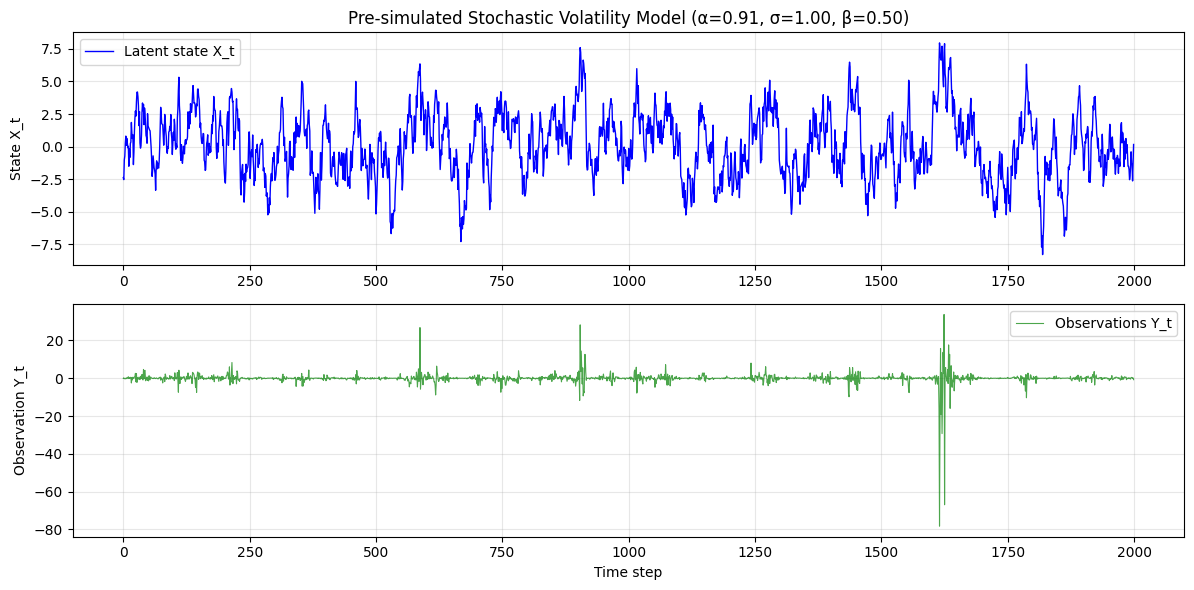

In [2]:
# Load pre-simulated stochastic volatility model data
data_path = '../simulator/data/sv_simul_data.npz'

# Load the data
data = np.load(data_path)

# Extract parameters and time series
X_true = data['X']
Y_obs = data['Y']
alpha = float(data['alpha'])
sigma = float(data['sigma'])
beta = float(data['beta'])
n = int(data['n'])
seed = data['seed'] if 'seed' in data else None

# Create a simple container similar to SV1DResults
class SVData:
    def __init__(self, X, Y, alpha, sigma, beta, n, seed):
        self.X = X
        self.Y = Y
        self.alpha = alpha
        self.sigma = sigma
        self.beta = beta
        self.n = n
        self.seed = seed

sv_data = SVData(X_true, Y_obs, alpha, sigma, beta, n, seed)

print(f"✓ Loaded pre-simulated SV data from: {data_path}")
print(f"  Number of time steps: {n}")
print(f"  Parameters: alpha={alpha:.3f}, sigma={sigma:.3f}, beta={beta:.3f}")
print(f"  Seed: {seed}")
print(f"  X shape: {sv_data.X.shape}, Y shape: {sv_data.Y.shape}")

# Plot the loaded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(sv_data.X, 'b-', linewidth=1, label='Latent state X_t')
ax1.set_ylabel('State X_t')
ax1.set_title(f'Pre-simulated Stochastic Volatility Model (α={alpha:.2f}, σ={sigma:.2f}, β={beta:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(sv_data.Y, 'g-', linewidth=0.8, alpha=0.7, label='Observations Y_t')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Observation Y_t')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Define SV model functions
def g_sv(x, u=None):
    """State transition: x_t = alpha * x_{t-1} + w_t"""
    return alpha * x

def h_sv(x):
    """Observation model: y_t = beta * exp(0.5 * x_t) * v_t"""
    return beta * np.exp(0.5 * x)

def jac_g_sv(x, u=None):
    """Jacobian of g w.r.t. x: dg/dx = alpha"""
    return np.array([[alpha]])

def jac_h_sv(x):
    """Jacobian of h w.r.t. x: dh/dx = 0.5 * beta * exp(0.5 * x)"""
    return np.array([[0.5 * beta * np.exp(0.5 * x[0])]])

# Noise covariances
Q = np.array([[sigma**2]])  # Process noise
R = np.array([[beta**2]])    # Measurement noise 

print("SV model functions defined")
print(f"Q = {Q}, R = {R}")

SV model functions defined
Q = [[1.]], R = [[0.25]]


In [4]:
def run_ekf_on_sv_data(Y, X_true, initial_mean, initial_cov):
    """Run EKF on SV data and track performance."""
    
    # Initialize filter
    ekf = ExtendedKalmanFilter(
        g=g_sv, 
        h=h_sv, 
        Q=Q, 
        R=R,
        jac_g=jac_g_sv,
        jac_h=jac_h_sv,
        joseph=True,
        jitter=1e-8
    )
    
    # Performance tracking
    process = psutil.Process()
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize state
    state = EKFState(mean=initial_mean, cov=initial_cov, t=0)
    
    # Storage for results
    X_est = np.zeros(len(Y))
    P_est = np.zeros(len(Y))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    
    # Run filter
    for t in range(1, len(Y)):
        state = ekf.predict(state)
        state = ekf.update(state, np.array([Y[t]]))
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
    
    # Performance metrics
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    results = {
        'X_est': X_est,
        'P_est': P_est,
        'runtime': runtime,
        'peak_memory_mb': peak / 1e6,
        'avg_time_per_step': runtime / len(Y)
    }
    
    return results

print("EKF runner defined")

EKF runner defined


In [5]:
def run_ukf_on_sv_data(Y, X_true, initial_mean, initial_cov):
    """Run UKF on SV data and track performance."""
    
    # Initialize filter
    ukf = UnscentedKalmanFilter(
        g=g_sv,
        h=h_sv,
        Q=Q,
        R=R,
        alpha=1e-3,
        beta=2.0,
        kappa=0.0,
        jitter=1e-8
    )
    
    # Performance tracking
    process = psutil.Process()
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize state
    state = UKFState(mean=initial_mean, cov=initial_cov, t=0)
    
    # Storage for results
    X_est = np.zeros(len(Y))
    P_est = np.zeros(len(Y))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    
    # Run filter
    for t in range(1, len(Y)):
        state = ukf.predict(state)
        state = ukf.update(state, np.array([Y[t]]))
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
    
    # Performance metrics
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    results = {
        'X_est': X_est,
        'P_est': P_est,
        'runtime': runtime,
        'peak_memory_mb': peak / 1e6,
        'avg_time_per_step': runtime / len(Y)
    }
    
    return results

print("UKF runner defined")

UKF runner defined


In [ ]:
def run_pf_on_sv_data(Y, X_true, initial_mean, initial_cov, Np=1000):
    """Run Particle Filter on SV data and track performance."""
    
    # Initialize filter
    pf = ParticleFilter(
        g=g_sv,
        h=h_sv,
        Q=Q,
        R=R,
        Np=Np,
        resample_thresh=0.5,
        resample_method='systematic',
        regularize_after_resample=True,
        rng=np.random.default_rng(42)
    )
    
    # Performance tracking
    process = psutil.Process()
    tracemalloc.start()
    start_time = time.perf_counter()
    
    # Initialize state
    state = pf.initialize(initial_mean, initial_cov)
    
    # Storage for results
    X_est = np.zeros(len(Y))
    P_est = np.zeros(len(Y))
    ess_history = np.zeros(len(Y))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    ess_history[0] = pf.effective_sample_size()
    
    # Run filter
    for t in range(1, len(Y)):
        pf.predict()  # Predict step (modifies pf.state internally)
        state = pf.update(np.array([Y[t]]))  # Update step (takes only measurement z)
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
        ess_history[t] = pf.effective_sample_size()
    
    # Performance metrics
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # PF-specific metrics
    degeneracy_fraction = np.mean(ess_history < 0.5 * Np)
    
    results = {
        'X_est': X_est,
        'P_est': P_est,
        'runtime': runtime,
        'peak_memory_mb': peak / 1e6,
        'avg_time_per_step': runtime / len(Y),
        'ess_history': ess_history,
        'degeneracy_fraction': degeneracy_fraction,
        'Np': Np
    }
    
    return results

print("PF runner defined")

PF runner defined


In [9]:
# Initial conditions (same for all filters)
initial_mean = np.array([0.0])
initial_cov = np.array([[1.0]])

print("="*60)
print("Running Extended Kalman Filter (EKF)...")
print("="*60)
ekf_results = run_ekf_on_sv_data(sv_data.Y, sv_data.X, initial_mean, initial_cov)
print(f"✓ EKF completed in {ekf_results['runtime']:.3f}s")
print(f"  Peak memory: {ekf_results['peak_memory_mb']:.2f} MB")
print(f"  Avg time/step: {ekf_results['avg_time_per_step']*1000:.4f} ms")

print("\n" + "="*60)
print("Running Unscented Kalman Filter (UKF)...")
print("="*60)
ukf_results = run_ukf_on_sv_data(sv_data.Y, sv_data.X, initial_mean, initial_cov)
print(f"✓ UKF completed in {ukf_results['runtime']:.3f}s")
print(f"  Peak memory: {ukf_results['peak_memory_mb']:.2f} MB")
print(f"  Avg time/step: {ukf_results['avg_time_per_step']*1000:.4f} ms")

print("\n" + "="*60)
print("Running Particle Filter (PF) with 1000 particles...")
print("="*60)
pf_results = run_pf_on_sv_data(sv_data.Y, sv_data.X, initial_mean, initial_cov, Np=1000)
print(f"✓ PF completed in {pf_results['runtime']:.3f}s")
print(f"  Peak memory: {pf_results['peak_memory_mb']:.2f} MB")
print(f"  Avg time/step: {pf_results['avg_time_per_step']*1000:.4f} ms")
print(f"  Degeneracy fraction: {pf_results['degeneracy_fraction']*100:.1f}%")

print("\n" + "="*60)
print("All filters completed successfully!")
print("="*60)

Running Extended Kalman Filter (EKF)...
✓ EKF completed in 0.246s
  Peak memory: 9.63 MB
  Avg time/step: 0.1230 ms

Running Unscented Kalman Filter (UKF)...
✓ UKF completed in 0.654s
  Peak memory: 0.04 MB
  Avg time/step: 0.3272 ms

Running Particle Filter (PF) with 1000 particles...
✓ UKF completed in 0.654s
  Peak memory: 0.04 MB
  Avg time/step: 0.3272 ms

Running Particle Filter (PF) with 1000 particles...
✓ PF completed in 20.475s
  Peak memory: 0.35 MB
  Avg time/step: 10.2376 ms
  Degeneracy fraction: 0.0%

All filters completed successfully!
✓ PF completed in 20.475s
  Peak memory: 0.35 MB
  Avg time/step: 10.2376 ms
  Degeneracy fraction: 0.0%

All filters completed successfully!


In [10]:
def compute_metrics(X_true, X_est, P_est):
    """Compute state estimation and uncertainty metrics."""
    
    # State estimation metrics
    errors = X_est - X_true
    rmse = np.sqrt(np.mean(errors**2))
    mae = np.mean(np.abs(errors))
    correlation = np.corrcoef(X_true, X_est)[0, 1]
    
    # Uncertainty calibration metrics
    std_est = np.sqrt(P_est)
    # 95% confidence interval
    lower = X_est - 1.96 * std_est
    upper = X_est + 1.96 * std_est
    coverage = np.mean((X_true >= lower) & (X_true <= upper)) * 100
    
    # Sharpness (average std)
    sharpness = np.mean(std_est)
    
    # CRPS-like metric (simplified as mean absolute prediction error weighted by uncertainty)
    crps = np.mean(np.abs(errors) / (std_est + 1e-10))
    
    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation,
        'Coverage_95%': coverage,
        'Sharpness': sharpness,
        'CRPS_scaled': crps
    }
    
    return metrics

# Compute metrics for all filters
print("Computing evaluation metrics...\n")

ekf_metrics = compute_metrics(sv_data.X, ekf_results['X_est'], ekf_results['P_est'])
ukf_metrics = compute_metrics(sv_data.X, ukf_results['X_est'], ukf_results['P_est'])
pf_metrics = compute_metrics(sv_data.X, pf_results['X_est'], pf_results['P_est'])

# Add performance metrics
ekf_metrics.update({
    'Runtime_s': ekf_results['runtime'],
    'Peak_Memory_MB': ekf_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': ekf_results['avg_time_per_step'] * 1000
})

ukf_metrics.update({
    'Runtime_s': ukf_results['runtime'],
    'Peak_Memory_MB': ukf_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': ukf_results['avg_time_per_step'] * 1000
})

pf_metrics.update({
    'Runtime_s': pf_results['runtime'],
    'Peak_Memory_MB': pf_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': pf_results['avg_time_per_step'] * 1000,
    'Degeneracy_%': pf_results['degeneracy_fraction'] * 100,
    'Num_Particles': pf_results['Np']
})

print("✓ Metrics computed successfully")

Computing evaluation metrics...

✓ Metrics computed successfully


In [11]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'EKF': ekf_metrics,
    'UKF': ukf_metrics,
    'PF': pf_metrics
}).T

# Reorder columns for better readability
metric_order = [
    'RMSE', 'MAE', 'Correlation', 
    'Coverage_95%', 'Sharpness', 'CRPS_scaled',
    'Runtime_s', 'Avg_Time_per_Step_ms', 'Peak_Memory_MB'
]

comparison_df = comparison_df[[col for col in metric_order if col in comparison_df.columns]]

print("="*80)
print("COMPARISON TABLE: EKF vs UKF vs PF on Stochastic Volatility Model")
print("="*80)
print(comparison_df.to_string())
print("="*80)

# Highlight best performance for each metric
print("\n" + "="*80)
print("BEST PERFORMER FOR EACH METRIC")
print("="*80)
for col in comparison_df.columns:
    if col in ['RMSE', 'MAE', 'CRPS_scaled', 'Runtime_s', 'Avg_Time_per_Step_ms', 'Peak_Memory_MB']:
        # Lower is better
        best = comparison_df[col].idxmin()
        best_val = comparison_df[col].min()
    else:
        # Higher is better (Correlation, Coverage)
        best = comparison_df[col].idxmax()
        best_val = comparison_df[col].max()
    print(f"{col:25s}: {best:5s} ({best_val:.4f})")
print("="*80)

COMPARISON TABLE: EKF vs UKF vs PF on Stochastic Volatility Model
         RMSE       MAE  Correlation  Coverage_95%  Sharpness  CRPS_scaled  Runtime_s  Avg_Time_per_Step_ms  Peak_Memory_MB
EKF  9.735010  4.191194    -0.251773         63.70   1.862932     2.355647   0.246072              0.123036        9.628075
UKF  7.705085  4.093414    -0.266841         63.85   1.963211     2.049726   0.654347              0.327174        0.043494
PF   3.450179  2.675603     0.310306         64.50   1.531795     8.903047  20.475294             10.237647        0.345777

BEST PERFORMER FOR EACH METRIC
RMSE                     : PF    (3.4502)
MAE                      : PF    (2.6756)
Correlation              : PF    (0.3103)
Coverage_95%             : PF    (64.5000)
Sharpness                : UKF   (1.9632)
CRPS_scaled              : UKF   (2.0497)
Runtime_s                : EKF   (0.2461)
Avg_Time_per_Step_ms     : EKF   (0.1230)
Peak_Memory_MB           : UKF   (0.0435)


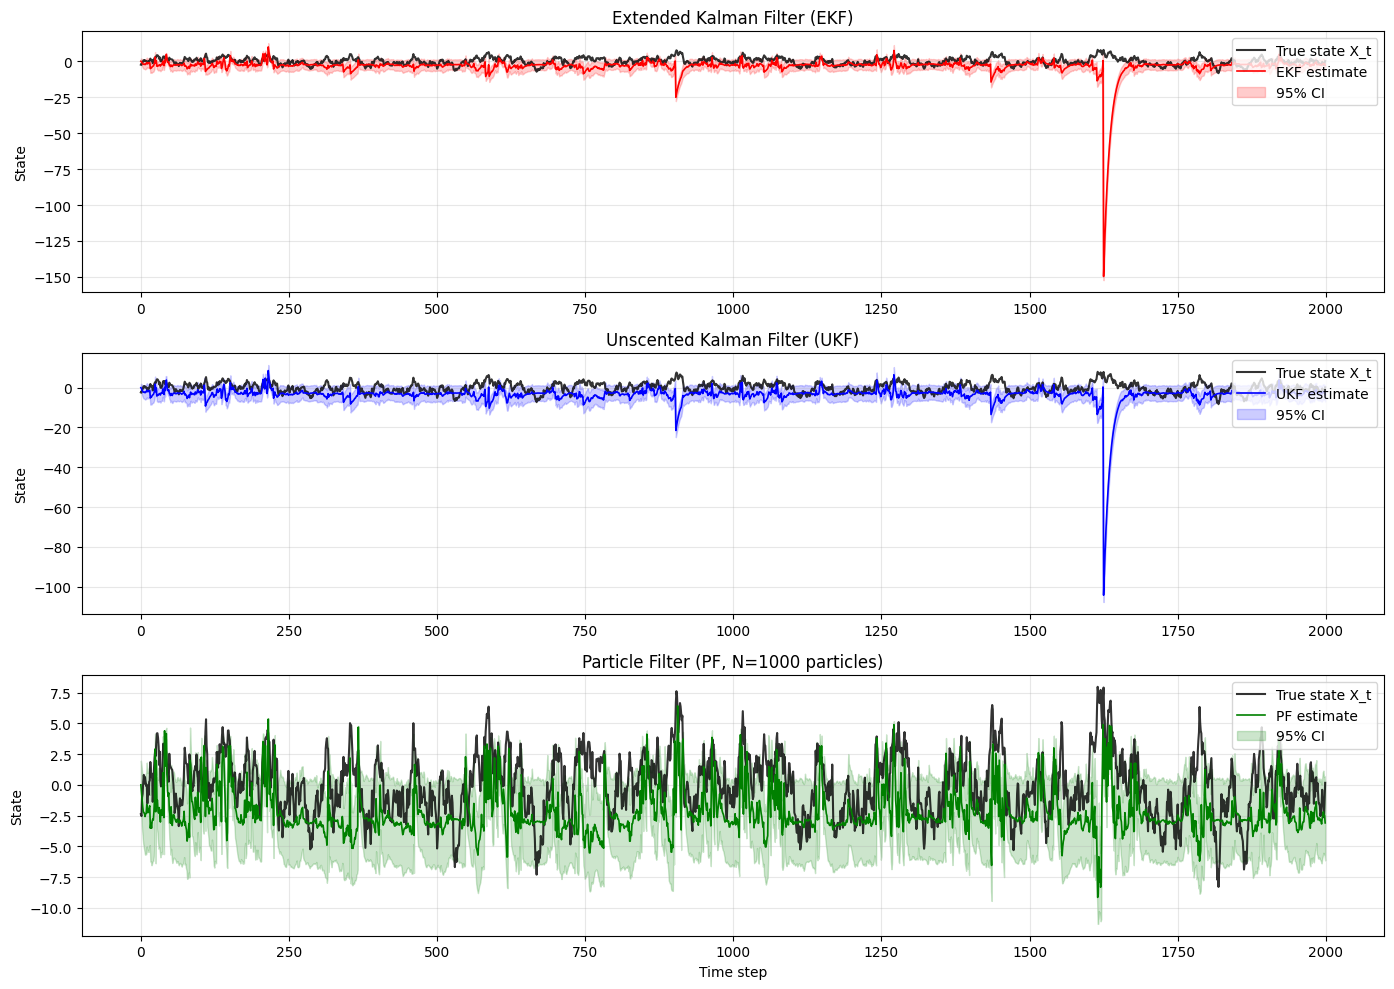

In [12]:
# Plot state estimates
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

time_steps = np.arange(n)

# EKF
ax = axes[0]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True state X_t', alpha=0.8)
ax.plot(time_steps, ekf_results['X_est'], 'r-', linewidth=1.2, label='EKF estimate')
std = np.sqrt(ekf_results['P_est'])
ax.fill_between(time_steps, 
                 ekf_results['X_est'] - 1.96*std, 
                 ekf_results['X_est'] + 1.96*std,
                 alpha=0.2, color='r', label='95% CI')
ax.set_ylabel('State')
ax.set_title('Extended Kalman Filter (EKF)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# UKF
ax = axes[1]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True state X_t', alpha=0.8)
ax.plot(time_steps, ukf_results['X_est'], 'b-', linewidth=1.2, label='UKF estimate')
std = np.sqrt(ukf_results['P_est'])
ax.fill_between(time_steps, 
                 ukf_results['X_est'] - 1.96*std, 
                 ukf_results['X_est'] + 1.96*std,
                 alpha=0.2, color='b', label='95% CI')
ax.set_ylabel('State')
ax.set_title('Unscented Kalman Filter (UKF)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# PF
ax = axes[2]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True state X_t', alpha=0.8)
ax.plot(time_steps, pf_results['X_est'], 'g-', linewidth=1.2, label='PF estimate')
std = np.sqrt(pf_results['P_est'])
ax.fill_between(time_steps, 
                 pf_results['X_est'] - 1.96*std, 
                 pf_results['X_est'] + 1.96*std,
                 alpha=0.2, color='g', label='95% CI')
ax.set_xlabel('Time step')
ax.set_ylabel('State')
ax.set_title(f'Particle Filter (PF, N={pf_results["Np"]} particles)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

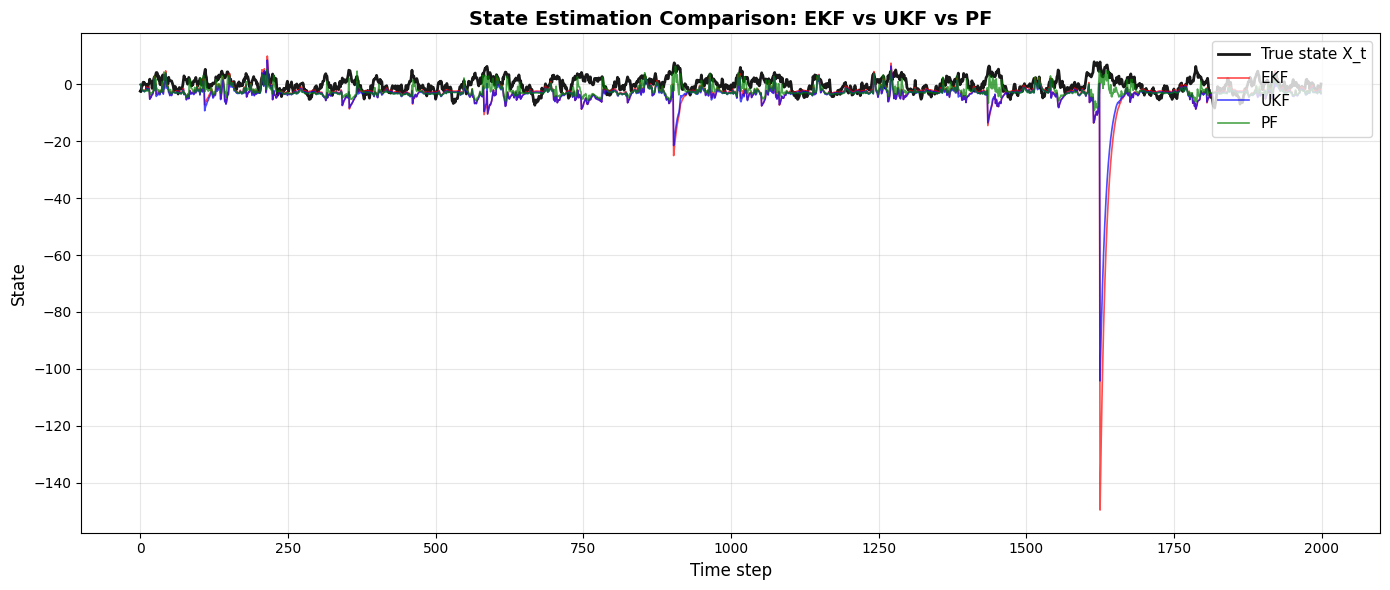

In [13]:
# Overlay all estimates
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(time_steps, sv_data.X, 'k-', linewidth=2, label='True state X_t', alpha=0.9)
ax.plot(time_steps, ekf_results['X_est'], 'r-', linewidth=1.2, label='EKF', alpha=0.7)
ax.plot(time_steps, ukf_results['X_est'], 'b-', linewidth=1.2, label='UKF', alpha=0.7)
ax.plot(time_steps, pf_results['X_est'], 'g-', linewidth=1.2, label='PF', alpha=0.7)

ax.set_xlabel('Time step', fontsize=12)
ax.set_ylabel('State', fontsize=12)
ax.set_title('State Estimation Comparison: EKF vs UKF vs PF', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

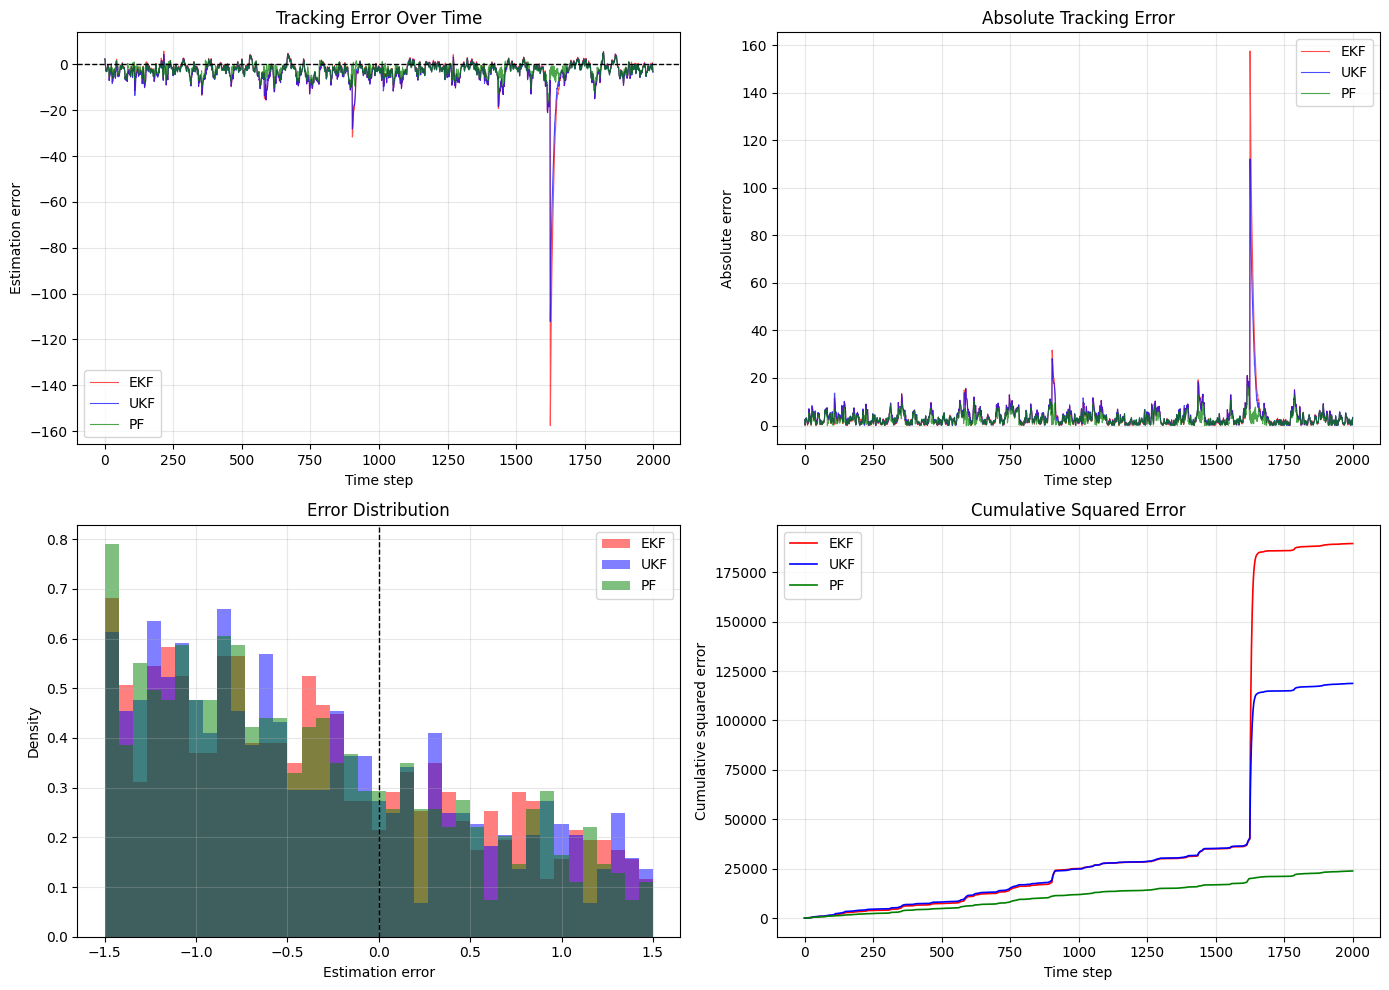

In [14]:
# Error analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tracking errors over time
ax = axes[0, 0]
ekf_errors = ekf_results['X_est'] - sv_data.X
ukf_errors = ukf_results['X_est'] - sv_data.X
pf_errors = pf_results['X_est'] - sv_data.X

ax.plot(time_steps, ekf_errors, 'r-', linewidth=0.8, label='EKF', alpha=0.7)
ax.plot(time_steps, ukf_errors, 'b-', linewidth=0.8, label='UKF', alpha=0.7)
ax.plot(time_steps, pf_errors, 'g-', linewidth=0.8, label='PF', alpha=0.7)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Time step')
ax.set_ylabel('Estimation error')
ax.set_title('Tracking Error Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Absolute errors
ax = axes[0, 1]
ax.plot(time_steps, np.abs(ekf_errors), 'r-', linewidth=0.8, label='EKF', alpha=0.7)
ax.plot(time_steps, np.abs(ukf_errors), 'b-', linewidth=0.8, label='UKF', alpha=0.7)
ax.plot(time_steps, np.abs(pf_errors), 'g-', linewidth=0.8, label='PF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Absolute error')
ax.set_title('Absolute Tracking Error')
ax.legend()
ax.grid(True, alpha=0.3)

# Error histograms
ax = axes[1, 0]
bins = np.linspace(-1.5, 1.5, 40)
ax.hist(ekf_errors, bins=bins, alpha=0.5, label='EKF', color='r', density=True)
ax.hist(ukf_errors, bins=bins, alpha=0.5, label='UKF', color='b', density=True)
ax.hist(pf_errors, bins=bins, alpha=0.5, label='PF', color='g', density=True)
ax.axvline(0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Estimation error')
ax.set_ylabel('Density')
ax.set_title('Error Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative squared error
ax = axes[1, 1]
ekf_cumse = np.cumsum(ekf_errors**2)
ukf_cumse = np.cumsum(ukf_errors**2)
pf_cumse = np.cumsum(pf_errors**2)

ax.plot(time_steps, ekf_cumse, 'r-', linewidth=1.2, label='EKF')
ax.plot(time_steps, ukf_cumse, 'b-', linewidth=1.2, label='UKF')
ax.plot(time_steps, pf_cumse, 'g-', linewidth=1.2, label='PF')
ax.set_xlabel('Time step')
ax.set_ylabel('Cumulative squared error')
ax.set_title('Cumulative Squared Error')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

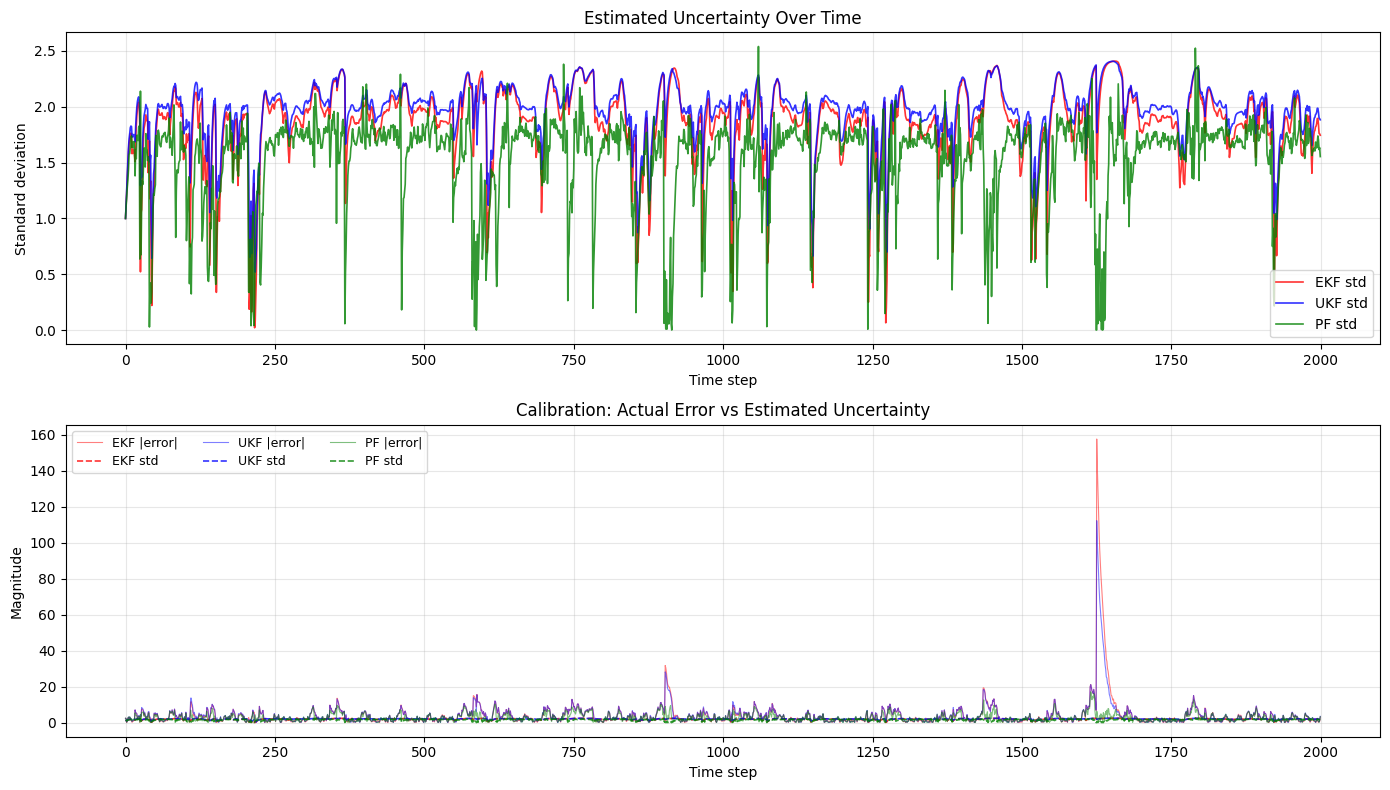

In [15]:
# Uncertainty (standard deviation) comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Standard deviation over time
ax = axes[0]
ekf_std = np.sqrt(ekf_results['P_est'])
ukf_std = np.sqrt(ukf_results['P_est'])
pf_std = np.sqrt(pf_results['P_est'])

ax.plot(time_steps, ekf_std, 'r-', linewidth=1.2, label='EKF std', alpha=0.8)
ax.plot(time_steps, ukf_std, 'b-', linewidth=1.2, label='UKF std', alpha=0.8)
ax.plot(time_steps, pf_std, 'g-', linewidth=1.2, label='PF std', alpha=0.8)
ax.set_xlabel('Time step')
ax.set_ylabel('Standard deviation')
ax.set_title('Estimated Uncertainty Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Actual absolute error vs estimated std
ax = axes[1]
ekf_abs_err = np.abs(ekf_results['X_est'] - sv_data.X)
ukf_abs_err = np.abs(ukf_results['X_est'] - sv_data.X)
pf_abs_err = np.abs(pf_results['X_est'] - sv_data.X)

# Plot both on same axis
ax.plot(time_steps, ekf_abs_err, 'r-', linewidth=0.8, alpha=0.5, label='EKF |error|')
ax.plot(time_steps, ekf_std, 'r--', linewidth=1.2, alpha=0.8, label='EKF std')
ax.plot(time_steps, ukf_abs_err, 'b-', linewidth=0.8, alpha=0.5, label='UKF |error|')
ax.plot(time_steps, ukf_std, 'b--', linewidth=1.2, alpha=0.8, label='UKF std')
ax.plot(time_steps, pf_abs_err, 'g-', linewidth=0.8, alpha=0.5, label='PF |error|')
ax.plot(time_steps, pf_std, 'g--', linewidth=1.2, alpha=0.8, label='PF std')

ax.set_xlabel('Time step')
ax.set_ylabel('Magnitude')
ax.set_title('Calibration: Actual Error vs Estimated Uncertainty')
ax.legend(ncol=3, fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

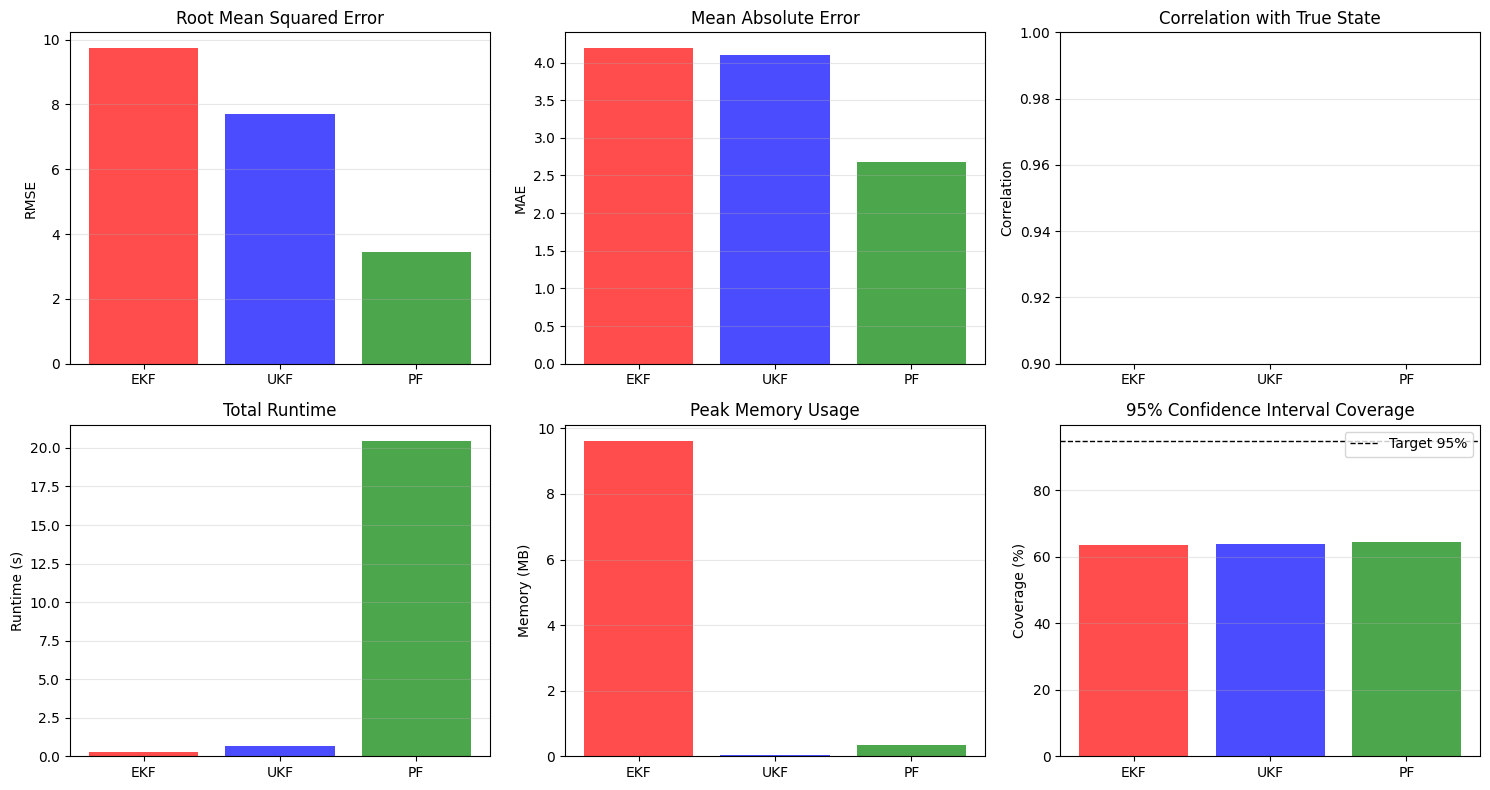

In [16]:
# Performance metrics bar charts
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

filters = ['EKF', 'UKF', 'PF']
colors = ['red', 'blue', 'green']

# RMSE
ax = axes[0, 0]
values = [ekf_metrics['RMSE'], ukf_metrics['RMSE'], pf_metrics['RMSE']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.set_ylabel('RMSE')
ax.set_title('Root Mean Squared Error')
ax.grid(True, alpha=0.3, axis='y')

# MAE
ax = axes[0, 1]
values = [ekf_metrics['MAE'], ukf_metrics['MAE'], pf_metrics['MAE']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.set_ylabel('MAE')
ax.set_title('Mean Absolute Error')
ax.grid(True, alpha=0.3, axis='y')

# Correlation
ax = axes[0, 2]
values = [ekf_metrics['Correlation'], ukf_metrics['Correlation'], pf_metrics['Correlation']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.set_ylabel('Correlation')
ax.set_title('Correlation with True State')
ax.set_ylim([0.9, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Runtime
ax = axes[1, 0]
values = [ekf_metrics['Runtime_s'], ukf_metrics['Runtime_s'], pf_metrics['Runtime_s']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.set_ylabel('Runtime (s)')
ax.set_title('Total Runtime')
ax.grid(True, alpha=0.3, axis='y')

# Memory
ax = axes[1, 1]
values = [ekf_metrics['Peak_Memory_MB'], ukf_metrics['Peak_Memory_MB'], pf_metrics['Peak_Memory_MB']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.set_ylabel('Memory (MB)')
ax.set_title('Peak Memory Usage')
ax.grid(True, alpha=0.3, axis='y')

# Coverage
ax = axes[1, 2]
values = [ekf_metrics['Coverage_95%'], ukf_metrics['Coverage_95%'], pf_metrics['Coverage_95%']]
ax.bar(filters, values, color=colors, alpha=0.7)
ax.axhline(95, color='black', linestyle='--', linewidth=1, label='Target 95%')
ax.set_ylabel('Coverage (%)')
ax.set_title('95% Confidence Interval Coverage')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

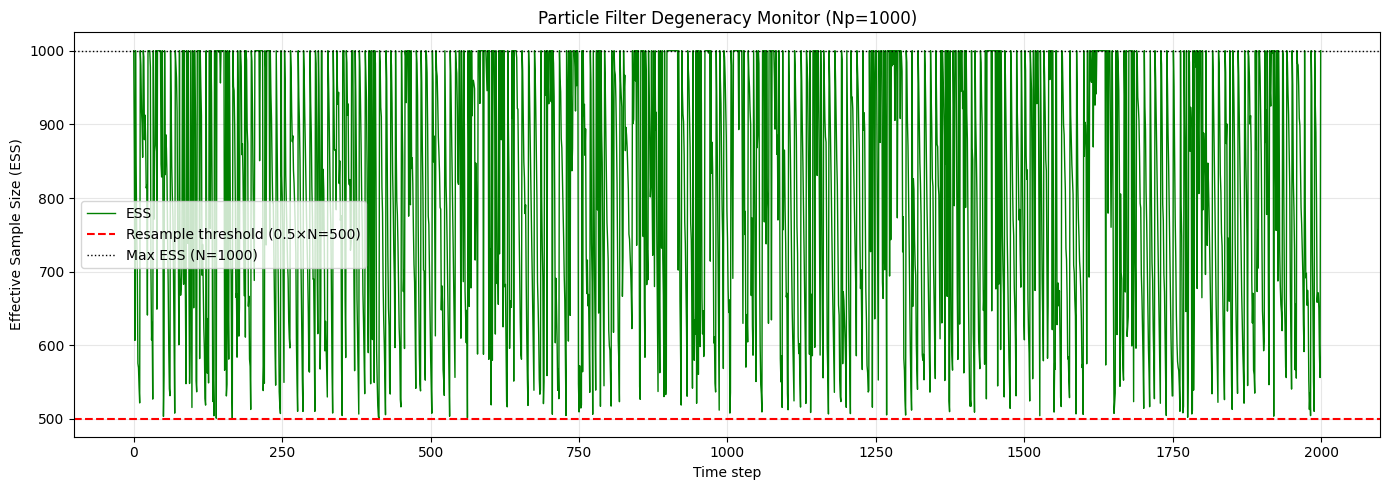

Average ESS: 806.4
Min ESS: 500.8
Degeneracy (ESS < 0.5×Np) occurred 0.0% of the time


In [17]:
# Effective Sample Size for Particle Filter
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(time_steps, pf_results['ess_history'], 'g-', linewidth=1, label='ESS')
ax.axhline(pf_results['Np'] * 0.5, color='red', linestyle='--', 
           linewidth=1.5, label=f'Resample threshold (0.5×N={pf_results["Np"]*0.5:.0f})')
ax.axhline(pf_results['Np'], color='black', linestyle=':', 
           linewidth=1, label=f'Max ESS (N={pf_results["Np"]})')

ax.set_xlabel('Time step')
ax.set_ylabel('Effective Sample Size (ESS)')
ax.set_title(f'Particle Filter Degeneracy Monitor (Np={pf_results["Np"]})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average ESS: {np.mean(pf_results['ess_history']):.1f}")
print(f"Min ESS: {np.min(pf_results['ess_history']):.1f}")
print(f"Degeneracy (ESS < 0.5×Np) occurred {pf_results['degeneracy_fraction']*100:.1f}% of the time")



## Log-Variance Transformation Comparison**

### **Alternative formulation: $Z_t = log(Y_t^2)$**

Instead of using raw observations $Y_t$, we can work with the log-variance transformation:
$Z_t = \log(Y_t^2)$

This transformation has theoretical advantages:
- **Linearizes the observation equation** in some formulations
- **Stabilizes variance** of the observations
- **Common in financial econometrics** for volatility modeling

We'll run the same three filters (EKF, UKF, PF) on this transformed observation space and compare results.

In [19]:
def run_ekf_on_logvar_data(Z, X_true, initial_mean, initial_cov):
    """Run EKF on log-variance transformed data."""
    ekf = ExtendedKalmanFilter(
        g=g_sv, 
        h=h_sv_logvar, 
        Q=Q_logvar, 
        R=R_logvar,
        jac_g=jac_g_sv,
        jac_h=jac_h_sv_logvar,
        joseph=True,
        jitter=1e-8
    )
    
    tracemalloc.start()
    start_time = time.perf_counter()
    state = EKFState(mean=initial_mean, cov=initial_cov, t=0)
    
    X_est = np.zeros(len(Z))
    P_est = np.zeros(len(Z))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    
    for t in range(1, len(Z)):
        state = ekf.predict(state)
        state = ekf.update(state, np.array([Z[t]]))
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
    
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    return {
        'X_est': X_est, 'P_est': P_est, 'runtime': runtime,
        'peak_memory_mb': peak / 1e6, 'avg_time_per_step': runtime / len(Z)
    }

def run_ukf_on_logvar_data(Z, X_true, initial_mean, initial_cov):
    """Run UKF on log-variance transformed data."""
    ukf = UnscentedKalmanFilter(
        g=g_sv, h=h_sv_logvar, Q=Q_logvar, R=R_logvar,
        alpha=1e-3, beta=2.0, kappa=0.0, jitter=1e-8
    )
    
    tracemalloc.start()
    start_time = time.perf_counter()
    state = UKFState(mean=initial_mean, cov=initial_cov, t=0)
    
    X_est = np.zeros(len(Z))
    P_est = np.zeros(len(Z))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    
    for t in range(1, len(Z)):
        state = ukf.predict(state)
        state = ukf.update(state, np.array([Z[t]]))
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
    
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    return {
        'X_est': X_est, 'P_est': P_est, 'runtime': runtime,
        'peak_memory_mb': peak / 1e6, 'avg_time_per_step': runtime / len(Z)
    }

def run_pf_on_logvar_data(Z, X_true, initial_mean, initial_cov, Np=1000):
    """Run PF on log-variance transformed data."""
    pf = ParticleFilter(
        g=g_sv, h=h_sv_logvar, Q=Q_logvar, R=R_logvar,
        Np=Np, resample_thresh=0.5, resample_method='systematic',
        regularize_after_resample=True, rng=np.random.default_rng(42)
    )
    
    tracemalloc.start()
    start_time = time.perf_counter()
    state = pf.initialize(initial_mean, initial_cov)
    
    X_est = np.zeros(len(Z))
    P_est = np.zeros(len(Z))
    ess_history = np.zeros(len(Z))
    X_est[0] = state.mean[0]
    P_est[0] = state.cov[0, 0]
    ess_history[0] = pf.effective_sample_size()
    
    for t in range(1, len(Z)):
        pf.predict()
        state = pf.update(np.array([Z[t]]))
        X_est[t] = state.mean[0]
        P_est[t] = state.cov[0, 0]
        ess_history[t] = pf.effective_sample_size()
    
    runtime = time.perf_counter() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    return {
        'X_est': X_est, 'P_est': P_est, 'runtime': runtime,
        'peak_memory_mb': peak / 1e6, 'avg_time_per_step': runtime / len(Z),
        'ess_history': ess_history, 'degeneracy_fraction': np.mean(ess_history < 0.5 * Np),
        'Np': Np
    }

print("Log-variance filter runners defined")

Log-variance filter runners defined


### **Log-variance model functions**

For the transformed observations, the measurement model becomes:
$Z_t = \log(Y_t^2) = \log(\beta^2 \exp(X_t) W_t^2) = \log(\beta^2) + X_t + \log(W_t^2)$

where $W_t \sim N(0,1)$, so $\log(W_t^2) \sim \log \chi^2_1$ distribution.

For filtering purposes, we approximate:
- **Mean**: $E[\log(W_t^2)] \approx -1.27$ (Euler-Mascheroni constant related)
- **Variance**: $Var[\log(W_t^2)] \approx \pi^2/2 \approx 4.93$

✓ Transformed observations to log-variance
  Original Y range: [-78.280, 33.740]
  Log-variance Z range: [-18.375, 8.721]
  Z shape: (2000,)


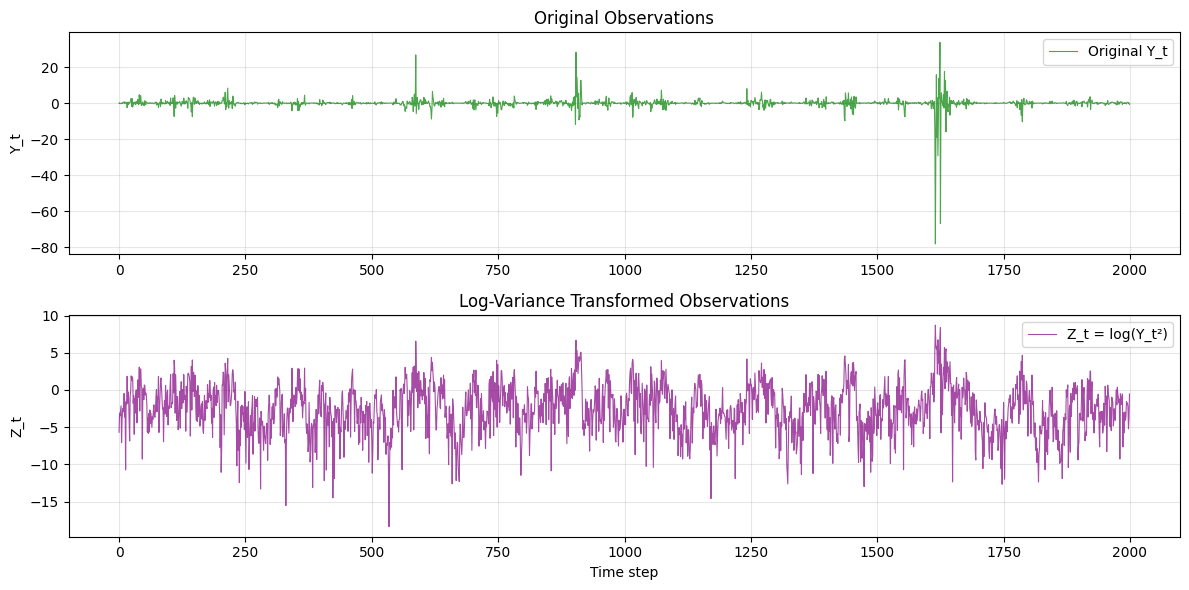

In [21]:
# Transform observations to log-variance: Z_t = log(Y_t^2)
# Handle zero/negative values by adding small constant
epsilon = 1e-10
Z_obs = np.log(sv_data.Y**2 + epsilon)

print(f"✓ Transformed observations to log-variance")
print(f"  Original Y range: [{np.min(sv_data.Y):.3f}, {np.max(sv_data.Y):.3f}]")
print(f"  Log-variance Z range: [{np.min(Z_obs):.3f}, {np.max(Z_obs):.3f}]")
print(f"  Z shape: {Z_obs.shape}")

# Plot original vs transformed observations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

time_steps = np.arange(len(sv_data.Y))

ax1.plot(time_steps, sv_data.Y, 'g-', linewidth=0.8, alpha=0.7, label='Original Y_t')
ax1.set_ylabel('Y_t')
ax1.set_title('Original Observations')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(time_steps, Z_obs, 'purple', linewidth=0.8, alpha=0.7, label='Z_t = log(Y_t²)')
ax2.set_xlabel('Time step')
ax2.set_ylabel('Z_t')
ax2.set_title('Log-Variance Transformed Observations')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Define log-variance SV model functions
# State transition remains the same: x_t = alpha * x_{t-1} + w_t
# Observation model: z_t = log(beta^2) + x_t + noise

# Constants for log-chi-squared distribution
log_chi2_mean = -1.2704  # E[log(W^2)] where W ~ N(0,1)
log_chi2_var = np.pi**2 / 2  # Var[log(W^2)] ≈ 4.93

def h_sv_logvar(x):
    """Observation model for log-variance: z_t = log(beta^2) + x_t + log(W^2)"""
    # Mean of the observation given state x
    return np.log(beta**2) + x + log_chi2_mean

def jac_h_sv_logvar(x):
    """Jacobian of log-variance observation model: dh/dx = 1"""
    return np.array([[1.0]])

# Noise covariances for log-variance model
Q_logvar = Q  # Process noise remains the same
R_logvar = np.array([[log_chi2_var]])  # Measurement noise variance from log(chi^2_1)

print("Log-variance SV model functions defined")
print(f"Q_logvar = {Q_logvar}")
print(f"R_logvar = {R_logvar} (≈ {log_chi2_var:.3f})")
print(f"Measurement offset: log(β²) + E[log(W²)] = {np.log(beta**2) + log_chi2_mean:.3f}")

Log-variance SV model functions defined
Q_logvar = [[1.]]
R_logvar = [[4.9348022]] (≈ 4.935)
Measurement offset: log(β²) + E[log(W²)] = -2.657


In [22]:
# Run all filters on log-variance data
print("="*60)
print("RUNNING FILTERS ON LOG-VARIANCE OBSERVATIONS")
print("="*60)

print("\nRunning EKF on log-variance data...")
ekf_logvar_results = run_ekf_on_logvar_data(Z_obs, sv_data.X, initial_mean, initial_cov)
print(f"✓ EKF-LogVar completed in {ekf_logvar_results['runtime']:.3f}s")

print("\nRunning UKF on log-variance data...")
ukf_logvar_results = run_ukf_on_logvar_data(Z_obs, sv_data.X, initial_mean, initial_cov)
print(f"✓ UKF-LogVar completed in {ukf_logvar_results['runtime']:.3f}s")

print("\nRunning PF on log-variance data...")
pf_logvar_results = run_pf_on_logvar_data(Z_obs, sv_data.X, initial_mean, initial_cov, Np=1000)
print(f"✓ PF-LogVar completed in {pf_logvar_results['runtime']:.3f}s")
print(f"  Degeneracy: {pf_logvar_results['degeneracy_fraction']*100:.1f}%")

print("\n" + "="*60)
print("All log-variance filters completed!")
print("="*60)

RUNNING FILTERS ON LOG-VARIANCE OBSERVATIONS

Running EKF on log-variance data...
✓ EKF-LogVar completed in 0.215s

Running UKF on log-variance data...
✓ EKF-LogVar completed in 0.215s

Running UKF on log-variance data...
✓ UKF-LogVar completed in 0.729s

Running PF on log-variance data...
✓ UKF-LogVar completed in 0.729s

Running PF on log-variance data...
✓ PF-LogVar completed in 22.376s
  Degeneracy: 0.0%

All log-variance filters completed!
✓ PF-LogVar completed in 22.376s
  Degeneracy: 0.0%

All log-variance filters completed!


In [23]:
# Compute metrics for log-variance results
ekf_logvar_metrics = compute_metrics(sv_data.X, ekf_logvar_results['X_est'], ekf_logvar_results['P_est'])
ukf_logvar_metrics = compute_metrics(sv_data.X, ukf_logvar_results['X_est'], ukf_logvar_results['P_est'])
pf_logvar_metrics = compute_metrics(sv_data.X, pf_logvar_results['X_est'], pf_logvar_results['P_est'])

ekf_logvar_metrics.update({
    'Runtime_s': ekf_logvar_results['runtime'],
    'Peak_Memory_MB': ekf_logvar_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': ekf_logvar_results['avg_time_per_step'] * 1000
})

ukf_logvar_metrics.update({
    'Runtime_s': ukf_logvar_results['runtime'],
    'Peak_Memory_MB': ukf_logvar_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': ukf_logvar_results['avg_time_per_step'] * 1000
})

pf_logvar_metrics.update({
    'Runtime_s': pf_logvar_results['runtime'],
    'Peak_Memory_MB': pf_logvar_results['peak_memory_mb'],
    'Avg_Time_per_Step_ms': pf_logvar_results['avg_time_per_step'] * 1000,
    'Degeneracy_%': pf_logvar_results['degeneracy_fraction'] * 100,
    'Num_Particles': pf_logvar_results['Np']
})

print("✓ Log-variance metrics computed")

✓ Log-variance metrics computed


In [ ]:
# Create comparison table: Original vs Log-Variance
comparison_logvar_df = pd.DataFrame({
    'EKF-Original': ekf_metrics,
    'EKF-LogVar': ekf_logvar_metrics,
    'UKF-Original': ukf_metrics,
    'UKF-LogVar': ukf_logvar_metrics,
    'PF-Original': pf_metrics,
    'PF-LogVar': pf_logvar_metrics
}).T

comparison_logvar_df = comparison_logvar_df[[col for col in metric_order if col in comparison_logvar_df.columns]]

print("="*90)
print("COMPARISON: ORIGINAL vs LOG-VARIANCE OBSERVATIONS")
print("="*90)
print(comparison_logvar_df.to_string())
print("="*90)

# Summary
print("\n" + "="*90)
print("PERFORMANCE COMPARISON: ORIGINAL vs LOG-VARIANCE")
print("="*90)
for filter_name in ['EKF', 'UKF', 'PF']:
    orig_rmse = comparison_logvar_df.loc[f'{filter_name}-Original', 'RMSE']
    logv_rmse = comparison_logvar_df.loc[f'{filter_name}-LogVar', 'RMSE']
    improvement = ((orig_rmse - logv_rmse) / orig_rmse) * 100
    better = "LogVar" if logv_rmse < orig_rmse else "Original"
    print(f"{filter_name:5s}: Original RMSE={orig_rmse:.4f}, LogVar RMSE={logv_rmse:.4f} → {better} is better ({abs(improvement):.1f}% diff)")
print("="*90)

COMPARISON: ORIGINAL vs LOG-VARIANCE OBSERVATIONS
                  RMSE       MAE  Correlation  Coverage_95%  Sharpness  CRPS_scaled  Runtime_s  Avg_Time_per_Step_ms  Peak_Memory_MB
EKF-Original  9.735010  4.191194    -0.251773         63.70   1.862932     2.355647   0.246072              0.123036        9.628075
EKF-LogVar    1.254017  0.987660     0.861479         95.10   1.252055     0.789037   0.215420              0.107710        0.045017
UKF-Original  7.705085  4.093414    -0.266841         63.85   1.963211     2.049726   0.654347              0.327174        0.043494
UKF-LogVar    1.254017  0.987660     0.861479         95.10   1.252055     0.789037   0.729191              0.364596        0.043028
PF-Original   3.450179  2.675603     0.310306         64.50   1.531795     8.903047  20.475294             10.237647        0.345777
PF-LogVar     1.252496  0.986226     0.861868         95.25   1.249617     0.791295  22.375995             11.187997        0.345578

PERFORMANCE COMPAR

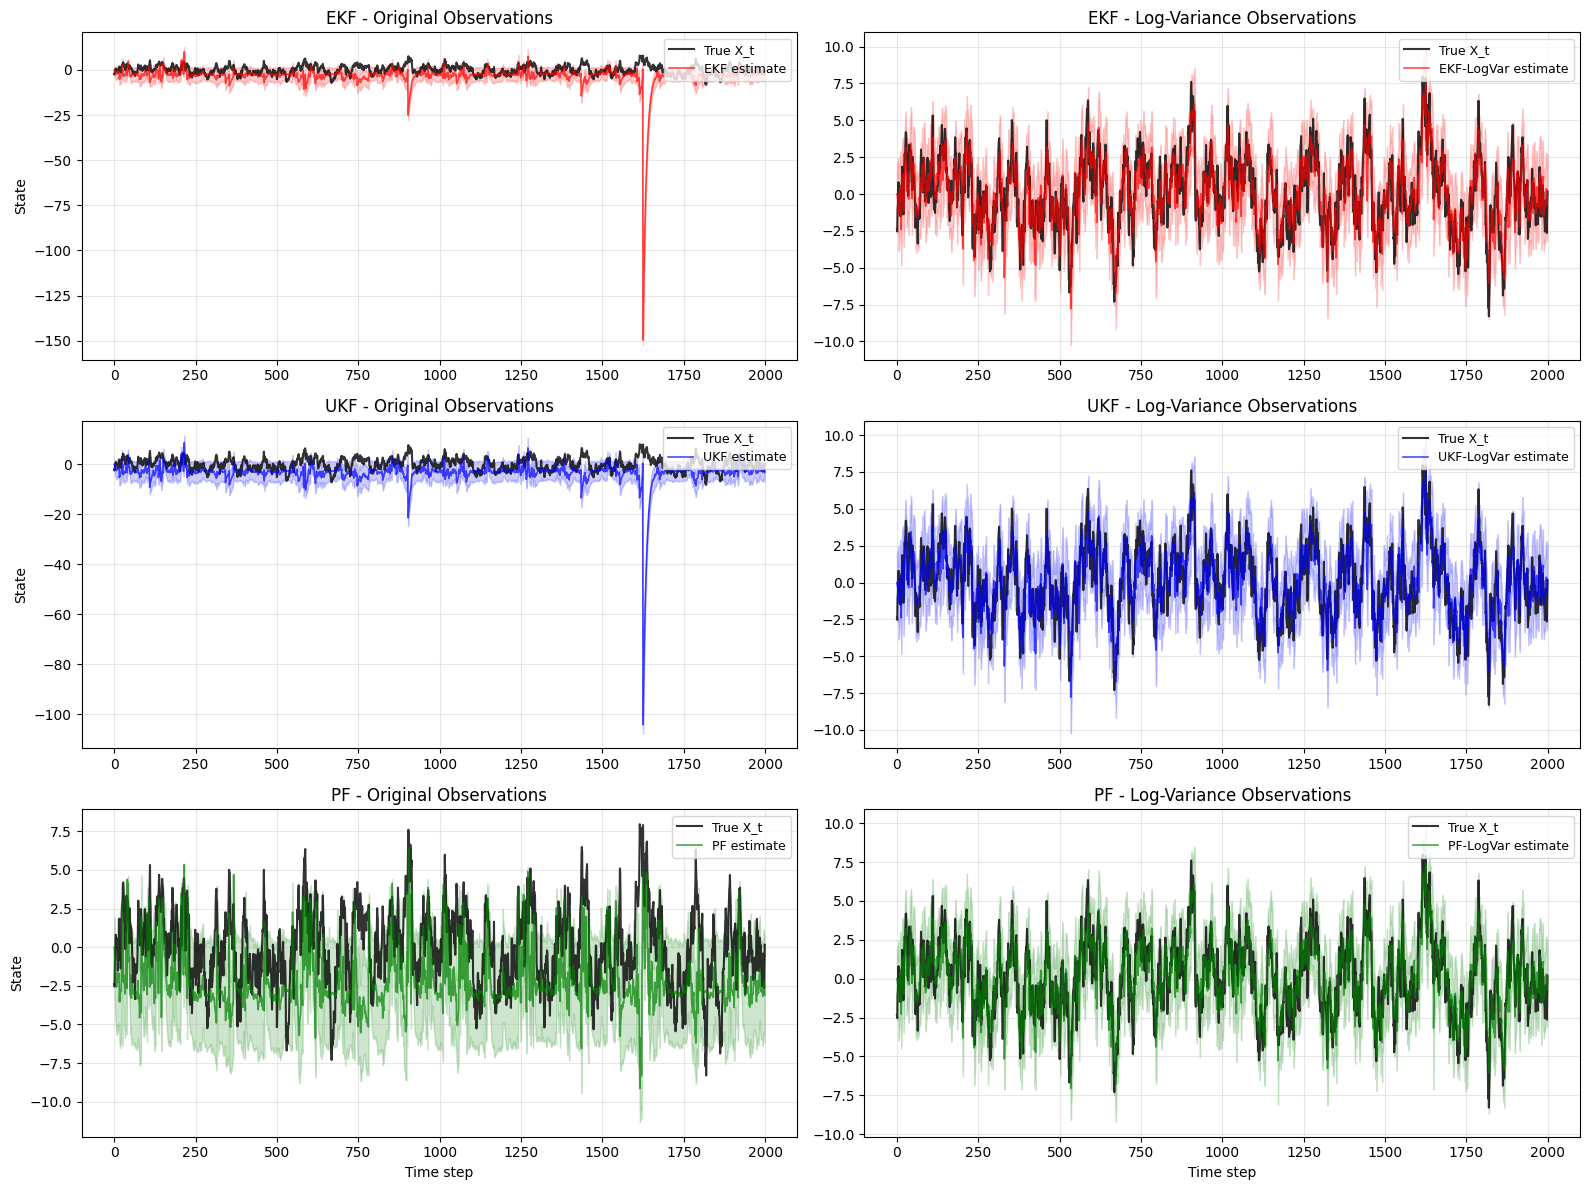

In [25]:
# Visualization: State tracking comparison (Original vs Log-Variance)
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

time_steps = np.arange(n)

# EKF - Original vs LogVar
ax = axes[0, 0]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, ekf_results['X_est'], 'r-', linewidth=1.2, label='EKF estimate', alpha=0.7)
std = np.sqrt(ekf_results['P_est'])
ax.fill_between(time_steps, ekf_results['X_est'] - 1.96*std, 
                 ekf_results['X_est'] + 1.96*std, alpha=0.2, color='r')
ax.set_ylabel('State')
ax.set_title('EKF - Original Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, ekf_logvar_results['X_est'], 'r-', linewidth=1.2, label='EKF-LogVar estimate', alpha=0.7)
std = np.sqrt(ekf_logvar_results['P_est'])
ax.fill_between(time_steps, ekf_logvar_results['X_est'] - 1.96*std, 
                 ekf_logvar_results['X_est'] + 1.96*std, alpha=0.2, color='r')
ax.set_title('EKF - Log-Variance Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# UKF - Original vs LogVar
ax = axes[1, 0]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, ukf_results['X_est'], 'b-', linewidth=1.2, label='UKF estimate', alpha=0.7)
std = np.sqrt(ukf_results['P_est'])
ax.fill_between(time_steps, ukf_results['X_est'] - 1.96*std, 
                 ukf_results['X_est'] + 1.96*std, alpha=0.2, color='b')
ax.set_ylabel('State')
ax.set_title('UKF - Original Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, ukf_logvar_results['X_est'], 'b-', linewidth=1.2, label='UKF-LogVar estimate', alpha=0.7)
std = np.sqrt(ukf_logvar_results['P_est'])
ax.fill_between(time_steps, ukf_logvar_results['X_est'] - 1.96*std, 
                 ukf_logvar_results['X_est'] + 1.96*std, alpha=0.2, color='b')
ax.set_title('UKF - Log-Variance Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# PF - Original vs LogVar
ax = axes[2, 0]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, pf_results['X_est'], 'g-', linewidth=1.2, label='PF estimate', alpha=0.7)
std = np.sqrt(pf_results['P_est'])
ax.fill_between(time_steps, pf_results['X_est'] - 1.96*std, 
                 pf_results['X_est'] + 1.96*std, alpha=0.2, color='g')
ax.set_xlabel('Time step')
ax.set_ylabel('State')
ax.set_title('PF - Original Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[2, 1]
ax.plot(time_steps, sv_data.X, 'k-', linewidth=1.5, label='True X_t', alpha=0.8)
ax.plot(time_steps, pf_logvar_results['X_est'], 'g-', linewidth=1.2, label='PF-LogVar estimate', alpha=0.7)
std = np.sqrt(pf_logvar_results['P_est'])
ax.fill_between(time_steps, pf_logvar_results['X_est'] - 1.96*std, 
                 pf_logvar_results['X_est'] + 1.96*std, alpha=0.2, color='g')
ax.set_xlabel('Time step')
ax.set_title('PF - Log-Variance Observations')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

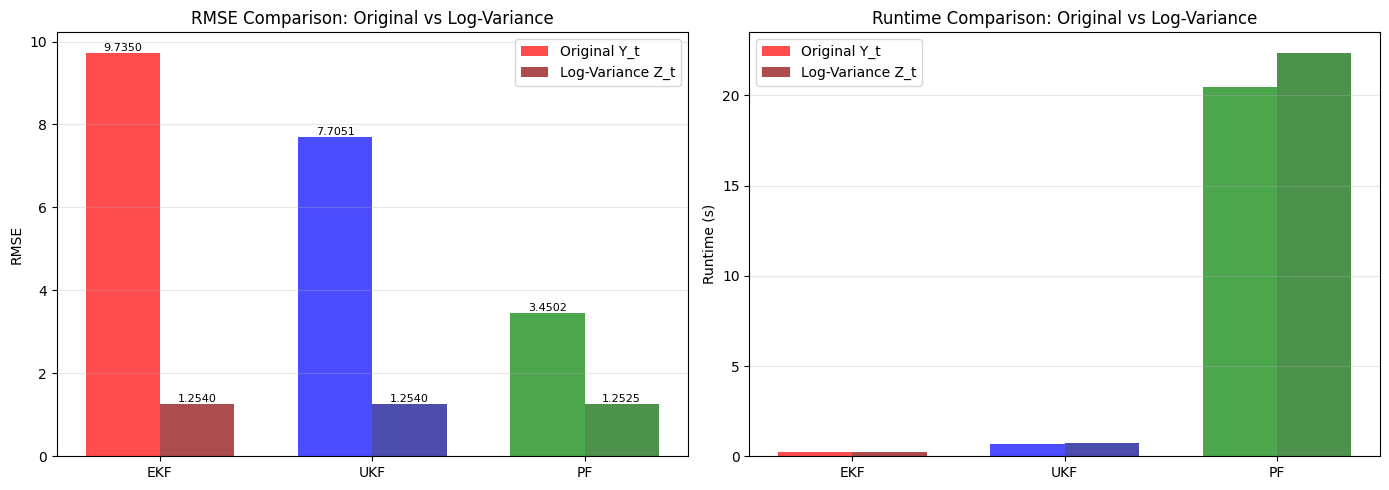

In [26]:
# Bar chart comparison: RMSE for all methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['EKF', 'UKF', 'PF']
original_rmse = [ekf_metrics['RMSE'], ukf_metrics['RMSE'], pf_metrics['RMSE']]
logvar_rmse = [ekf_logvar_metrics['RMSE'], ukf_logvar_metrics['RMSE'], pf_logvar_metrics['RMSE']]

x = np.arange(len(methods))
width = 0.35

ax = axes[0]
bars1 = ax.bar(x - width/2, original_rmse, width, label='Original Y_t', color=['red', 'blue', 'green'], alpha=0.7)
bars2 = ax.bar(x + width/2, logvar_rmse, width, label='Log-Variance Z_t', color=['darkred', 'darkblue', 'darkgreen'], alpha=0.7)
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Original vs Log-Variance')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontsize=8)

# Runtime comparison
original_runtime = [ekf_metrics['Runtime_s'], ukf_metrics['Runtime_s'], pf_metrics['Runtime_s']]
logvar_runtime = [ekf_logvar_metrics['Runtime_s'], ukf_logvar_metrics['Runtime_s'], pf_logvar_metrics['Runtime_s']]

ax = axes[1]
bars1 = ax.bar(x - width/2, original_runtime, width, label='Original Y_t', color=['red', 'blue', 'green'], alpha=0.7)
bars2 = ax.bar(x + width/2, logvar_runtime, width, label='Log-Variance Z_t', color=['darkred', 'darkblue', 'darkgreen'], alpha=0.7)
ax.set_ylabel('Runtime (s)')
ax.set_title('Runtime Comparison: Original vs Log-Variance')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()